# A Demonstration of our proposed Inverting Stochasticity from Gradients (ISG) Attack

## Importing Required Libraries

In [1]:
import os
import torch
import ISG
import IG
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from arch.model import VBMLP
import torchvision.transforms as transforms
from torch.nn.functional import mse_loss
from torchmetrics.functional.image import structural_similarity_index_measure, learned_perceptual_image_patch_similarity

In [2]:
device = torch.device(f'gpu')
setup = dict(device=device, dtype=torch.float)
loss_fn = torch.nn.CrossEntropyLoss()

## Load a victim CIFAR-10 image

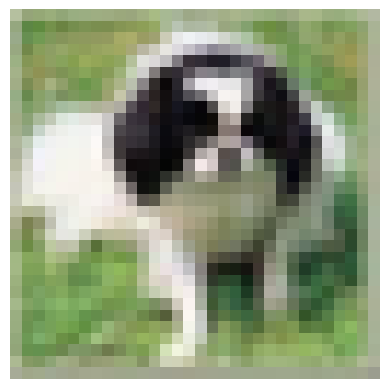

In [3]:
image = Image.open('7.png')

# Define transformations
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transform = transforms.Compose([
    # Normalize pixel values to [-1, 1]
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, 
                         std=std)
])
dm, ds = torch.as_tensor(mean, **setup)[:, None, None], torch.as_tensor(std, **setup)[:, None, None]

# Apply the transformations
image_transformed = transform(image)
# Add a batch dimension (the model expects a batch, even if it's a batch of one)
# This will change the shape from [C, H, W] to [1, C, H, W]
image_batch = image_transformed.unsqueeze(0).to(device)
# random assign a label to the image
label_batch = torch.tensor([1,], dtype=torch.int64).to(device)

def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        plt.imshow(tensor[0].permute(1, 2, 0).cpu())
        plt.axis('off')
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu())
            plt.axis('off')

plot(image_batch)

# Load the victim model

In [4]:
victim_model = VBMLP()
victim_model.to(**setup)

parameters = dict(models=[], multipliers=[], eps=[])
for name, p in victim_model.named_parameters():
    # feature regularization multiplier "m", here we don't have it, as the victim model is fully connected
    if 'multiplier' in name:
        parameters['multipliers'].append(p)
    # learnable intermediate noise
    elif 'eps' in name:
        continue
        # parameters['eps'].append(p)
    # the model parameters
    else:
        parameters['models'].append(p)
print(victim_model)

VBMLP(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=3072, out_features=1024, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=10, bias=True)
  (vb): VariationalBottleneck(
    (encoder): Linear(in_features=1024, out_features=512, bias=True)
    (decoder): Linear(in_features=256, out_features=1024, bias=True)
  )
)


## Compute the true gradients

In [5]:
# clear the gradient and re-initialize the weights
victim_model.zero_grad()
# randomly sample features
victim_model.flag = 0

# victim_model.loss() refers to the KLD between posteriors and priors
target_loss = loss_fn(victim_model(image_batch), label_batch) + victim_model.loss()
input_gradient = torch.autograd.grad(target_loss, parameters['models'])

## Reconstruct the training image from gradients by using *Inverting Gradients* (IG) approach 

### Configure the experimental setup

In [6]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=3200,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss',
              )

rec_machine = IG.GradientReconstructor(
    victim_model, (dm, ds), config, num_images=1
)

Reconstructing ...

In [7]:
# use another features to reconstruct the training data
victim_model.zero_grad()
victim_model.flag = 1

dummy_images, _ = \
            rec_machine.reconstruct(
                input_gradient, label_batch, img_shape=(3, 32, 32)
            )

It: 0. Rec. loss: 0.8370.
It: 500. Rec. loss: 0.4680.
It: 1000. Rec. loss: 0.4678.
It: 1500. Rec. loss: 0.4681.
It: 2000. Rec. loss: 0.4671.
It: 2500. Rec. loss: 0.4672.
It: 3000. Rec. loss: 0.4689.
It: 3199. Rec. loss: 0.4673.
Choosing optimal result ...
Optimal result score: 0.4678
Total time: 36.99805808067322.


## Assess the quality of the reconstructed image

MSE: 4.138245582580566 
PSNR: -3.0840814113616943 
SSIM: 0.024826234206557274


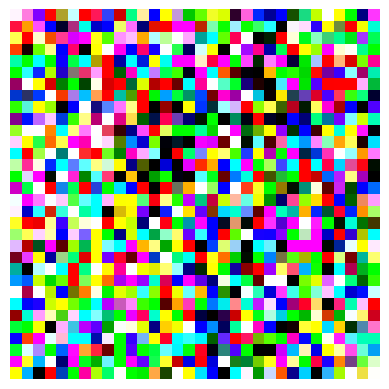

In [8]:
MSE = torch.mean(mse_loss(dummy_images, image_batch, reduction='none'))
PSNR = 10 * torch.log10(1.0 / (torch.sqrt(MSE) + 1e-8))
SSIM = structural_similarity_index_measure(dummy_images, image_batch, data_range=1.0, reduction='none').item()

print(f'MSE: {MSE} \nPSNR: {PSNR} \nSSIM: {SSIM}')
plot(dummy_images)

## Reconstruct the training image from gradients by using our approach (ISG)

In [9]:
# hook the intermediate noise which is going to be optimized
for name, p in victim_model.named_parameters():
    if 'eps' in name:
        parameters['eps'].append(p)

# experimental setup
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=3200,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss',
              )

rec_machine = ISG.GradientReconstructor(
    victim_model, parameters, (dm, ds), config, num_images=1
)


# use the jointly-optimized features to reconstruct
victim_model.zero_grad()
victim_model.flag = 2

dummy_images, dummy_labels, _ = \
            rec_machine.reconstruct(
                input_gradient, label_batch, img_shape=(3, 32, 32)
            )

It: 0. Rec. loss: 1.0753.
It: 500. Rec. loss: 0.0020.
It: 1000. Rec. loss: 0.0038.
It: 1500. Rec. loss: 0.0016.
It: 2000. Rec. loss: 0.0011.
It: 2500. Rec. loss: 0.0012.
It: 3000. Rec. loss: 0.0012.
It: 3199. Rec. loss: 0.0012.
Choosing optimal result ...
Optimal result score: 0.0015
Total time: 32.60810208320618.


## Assessing the Quality of Our Reconstructed Image

MSE: 0.00023445030092261732 
PSNR: 18.149742126464844 
SSIM: 0.9993909597396851


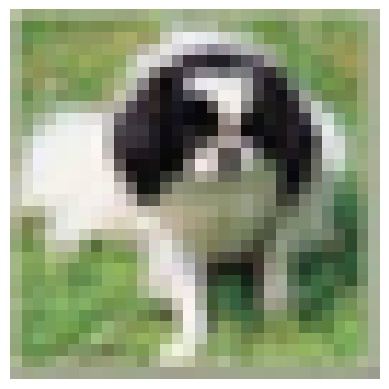

In [10]:
MSE = torch.mean(mse_loss(dummy_images, image_batch, reduction='none'))
PSNR = 10 * torch.log10(1.0 / (torch.sqrt(MSE) + 1e-8))
SSIM = structural_similarity_index_measure(dummy_images, image_batch, data_range=1.0, reduction='none').item()

print(f'MSE: {MSE} \nPSNR: {PSNR} \nSSIM: {SSIM}')
plot(dummy_images)

## Used Official Repositories:
- Repository of IG: https://github.com/JonasGeiping/invertinggradients
- Repository of VBMLP: https://github.com/dAI-SY-Group/PRECODE/blob/master/PRECODE.ipynb

## Reference
- Scheliga, Daniel et al. “PRECODE - A Generic Model Extension to Prevent Deep Gradient Leakage.” 2022 IEEE/CVF Winter Conference on Applications of Computer Vision (WACV) (2021): 3605-3614.
- Geiping, Jonas, et al. "Inverting gradients-how easy is it to break privacy in federated learning?." Advances in neural information processing systems 33 (2020): 16937-16947.